Intuitive control trajectory generation
==============================================================================

This module generates trajectories using "intuitive control"



Imports and initialization
------------------------------------------------------------------------------

In [ ]:
#imports and juptyter magic
#------------------------------------------------------------------------------

#python builtin imports
from os.path import dirname
import copy
from math import pi
import threading
import time

#anaconda imports
import numpy as np
from matplotlib.pyplot import plot, figure, legend
import matplotlib.pyplot as plt
import ipywidgets as widgets
import ipdb


#for the widgets
import ipywidgets as widgets
from math import pi
from ipywidgets import interactive
from mujoco_py.generated import const

#mujoco 
import mujoco_py as mj

#helpers we wrote
import mujoco_walker_helpers as mh

#jupyter magic
%matplotlib inline


#Load the model
#------------------------------------------------------------------------------

model_xml = open('walker.xml').read()
model = mj.load_model_from_xml(model_xml)
sim = mj.MjSim(model)
viewer = mj.MjViewer(sim)

num_pos = num_vel = num_u = 6

# Get the indexes for all our joints (!! note, rooty is actaually the ANGLE of thigh 1 relative to tbe baseframe (don't look at me I didn't write the XML file))
#------------------------------------------------------------------------------

#leg 1 is by default rendered in pink, leg 2 in beige
thigh1_i = sim.model.get_joint_qpos_addr('thigh_joint') #absolute angle of thigh 1 
thigh2_i = sim.model.get_joint_qpos_addr('thigh_left_joint') #absolute angle of thigh2 

leg1_i = sim.model.get_joint_qpos_addr('leg_joint') #relative angle of thigh1 to leg1
leg2_i = sim.model.get_joint_qpos_addr('leg_left_joint')  #relative angle of thigh2 to leg2

foot1_i = sim.model.get_joint_qpos_addr('foot_joint') #relative angle of leg1 to foot 1 (0 degrees == perpendicular foot)
foot2_i = sim.model.get_joint_qpos_addr('foot_left_joint') #relative angle of leg1 to foot 1 (0 degrees == perpendicular foot)

#get indexes for world position and orientation (z is always zero since we are in 2D)

rootx_i = sim.model.get_joint_qpos_addr('rootx') 
rooty_i = sim.model.get_joint_qpos_addr('rooty') #Note Root Y is actually an ANGLE!!
rootz_i = sim.model.get_joint_qpos_addr('rootz')

# set the default state (determined empirically)
#------------------------------------------------------------------------------
default_state = copy.deepcopy(sim.get_state()) #we want to hold onto default_state 
#default_state[1][:] =  [0.     ,  0    , 0.04159,  -0.44841, -1.09159,  -0.04841,  0.62159, -0.05159,  0.] #more or less arbitrary
#default_state[1][:] =  [0.     ,  0    , 0.2,  -pi/7, -1,  -0.04841,  pi/7, -1,  0.] #more or less arbitrary
default_state[1][:] = [0., 1.38607342, -0.19159 ,  0.53841, -1.04159 , 0.36841 , -0.03159 , -0.84159 , 0.72841]

#run the sim forward everything gets updated and we can query the positions of everything correctly
sim.set_state(default_state)
sim.forward()

default_state[1][rootz_i] = mh.find_contact_height(sim)

sim.set_state(default_state)
sim.forward

In [23]:
#convience infinite render loop, run to interactively view the robot before running the simulation, interput the kernel to kill this cell
while(True):
    viewer.render()

KeyboardInterrupt: 

Interactive Visualizer
------------------------------------------------------------------------------
Run this cell to see how the robot will look with some set of joint configurations (note this next cell will probably not work outside of jupyter and def won't work outside of ipython

You'll need ipywidgets to get this to work (and thus it will only work with ipython). https://ipywidgets.readthedocs.io/en/stable/user_install.html 

Make sure you also ACTIVATE the installation if you are using jupyter, notebook and lab have different ways to do that, it's all in that link above. 

In [6]:
viewer.cam.fixedcamid = 0
viewer.cam.type = const.CAMERA_FIXED
state = sim.get_state()
state[1][1] = 5
sim.set_state(state)

#I know what your thinking: why have th0,th1,th2? why not put them in a list?? well I tried that and widgets chokes, using *args wasn't succsseful either, so here we are
@widgets.interact_manual()
def set_state_and_render(rootx = (-10,10,.01), rootz = (-10,10,.01), rooty = (-pi,pi,.01),
                        th0 = (-pi, pi,.01) ,th1 = (-pi, pi,.01) ,th2 = (-pi, pi,.01) 
                         ,th3 = (-pi, pi,.01),th4 = (-pi, pi,.01),th5 = (-pi, pi,.01)):
    global sim
    global viewer
    print(th0)
    print(th1)
    state = sim.get_state()
    state[1][:] = [rootx, rootz, rooty, th0,th1,th2,th3,th4,th5]
    sim.set_state(state)
    
    #run the sim forward everything gets updated and we can query the positions of everything correctly
    sim.forward()

    #this block  will set the z origin such that our minimum z point is in contact with the ground
    zmin = sim.data.body_xpos[1:-1].min(axis = 0)[2]# looks weird but this gives us the minimum z position of any body (except the world frame, hence 1:-1 rather than 0:-1)
    arg_zmin = sim.data.body_xpos[1:-1].argmin(axis = 0)[2]
    body_size_zmin = sim.model.geom_rbound[arg_zmin]
    zmin = zmin - body_size_zmin
    state[1][1] = -zmin
    sim.set_state(state)
    sim.forward()

    
    #the fact that this is in a loop is a hack, for some reason I would have to call this function ~10-20 times for it to update properly
    for i in range(50):
        sim.forward()
        viewer.render()

    #sim.step()
    #time.sleep(5)

interactive(children=(FloatSlider(value=0.0, description='rootx', max=10.0, min=-10.0, step=0.01), FloatSlider…

In [9]:
pygame.init()
pygame.display.set_mode((100,100))

state = sim.get_state()
state[1][1] = 5
sim.set_state(state)
print(viewer.cam.fixedcamid)
viewer.cam.fixedcamid = 0
viewer.cam.type = const.CAMERA_FIXED

num_steps = 1000
q_pos = np.zeros((num_steps, num_pos))
q_vel = np.zeros((num_steps, num_vel))
u_vals = np.zeros((num_steps, num_u))



@widgets.interact_manual()
def set_ctrl_and_run(th0 = (-pi, pi,.01) ,th1 = (-pi, pi,.01) ,th2 = (-pi, pi,.01), 
                         th3 = (-pi, pi,.01),th4 = (-pi, pi,.01),th5 = (-pi, pi,.01), 
                         ctrl0 = (-1, 1,.01), ctrl1 = (-1, 1,.01), ctrl2 = (-1, 1,.01),
                         ctrl3 = (-1, 1,.01), ctrl4 = (-1, 1,.01), ctrl5 = (-1,1,.01)):
    global sim
    global viewer
    
    while(True):

    #print(ctrl0)
    #print(ctrl1)
        state = sim.get_state()
        state[1][2:-1] = [th0,th1,th2,th3,th4,th5]
        #print(sim.data.ctrl)
        sim.data.ctrl[:] = [ctrl0, ctrl1, ctrl2, ctrl3, ctrl4, ctrl5]
        #print(sim.data.ctrl)
        sim.set_state(state)    
        for i in range(num_steps):
            sim.step()
            sim.data.ctrl[:] = [ctrl0, ctrl1, ctrl2, ctrl3, ctrl4, ctrl5]
            viewer.render()
            
            q_pos[i,:] = sim.get_state()[1][2:-1]
            q_vel[i,:] = sim.get_state()[2][2:-1]


            u_vals[i,:] = sim.data.ctrl[:]
            
    
        sim.reset()
        state = sim.get_state()
        state[1][1] = 50
        sim.set_state(state)
        
        if any(pygame.key.get_pressed()):
            print("got it")
            break

       


-1


interactive(children=(FloatSlider(value=-0.0015926535897929917, description='th0', max=3.141592653589793, min=…

Main simulation
==============================================================================

In [60]:
sim.reset()
sim.set_state(default_state) #reset everything at the end of the loop

p_gains = .2*np.ones(sim.data.ctrl.size)
p_gains[leg2_i - 3] = -p_gains[leg2_i - 3]
#p_gains[2] = 1
#p_gains[5] = 1
d_gains = 0*np.ones(sim.data.ctrl.size)
set_points1 = default_state[1]
set_points2 = set_points1

#set_points1 = np.array([0,0,0,pi/7, 0, 0 , -pi/7, 0 ,0]) #used while thigh1 is behind thigh2
#set_points2 = set_points1 #used when the thighs gets switched 
#set_points2[0] = -set_points1[0]
#set_points2[3] = -set_points1[3]
#set_points2[1] = -pi/7
#set_points2[4] = -pi/7

num_steps = 1000
num_pos = default_state[1].size
num_vel = default_state[2].size
num_u = sim.data.ctrl.size

q_pos_hist = np.zeros((num_steps, num_pos))
q_vel_hist = np.zeros((num_steps, num_vel))
u_vals_hist = np.zeros((num_steps, num_u))

printed_1 = False
printed_2 = False


#Loop through forever, so that we can interact with the GUI 
while True:
    for i in range(num_steps):
        
        q_pos = sim.get_state()[1]
        q_vel = sim.get_state()[2]
        
        #if thigh1 is behind thigh2 we have one set of set points, after they cross we switch to the second
        if(q_pos[thigh1_i] > q_pos[thigh2_i]):
            sim.data.ctrl[:] = (set_points1[2:-1] - q_pos[2:-1])*p_gains + (np.zeros((1,6)) - q_vel[2:-1])*d_gains
            #sim.data.ctrl[:] = (set_points1[2:-1] - q_pos[2:-1])*p_gains
            
            if not printed_1:
                print("1")
                printed_1 = True

        elif q_pos[thigh1_i] <= q_pos[thigh2_i]:
            sim.data.ctrl[:] = (set_points2[2:-1] - q_pos[2:-1])*p_gains +(np.zeros((1,6)) - q_vel[2:-1])*d_gains
            #sim.data.ctrl[:] = (set_points2[2:-1] - q_pos[2:-1])*p_gains

            
            if not printed_2:
                print("2")
                printed_2 = True

        #store the data no matter what   
        q_pos_hist[i,:] = q_pos
        q_vel_hist[i,:] = q_vel
        u_vals_hist[i,:] = sim.data.ctrl[:]

        sim.step()
        viewer.render() 
    
    
    
    sim.set_state(default_state) #reset everything at the end of the loop

1


KeyboardInterrupt: 

In [32]:
#Store Q vals, run this cell to export these vals to another notebook, use %store -r q_pos (or whatever variable) to load these in another python 3 notebook
%store q_pos
%store q_vel
%store u_vals

Stored 'q_pos' (ndarray)
Stored 'q_vel' (ndarray)


UsageError: Unknown variable 'u_vals'


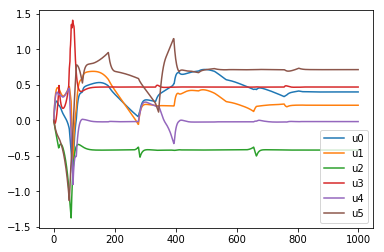

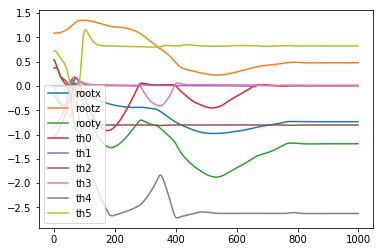

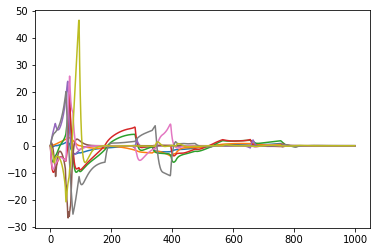

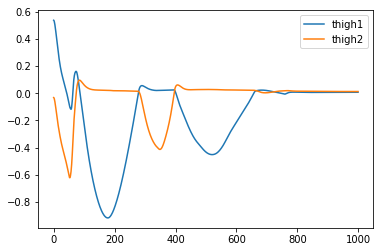

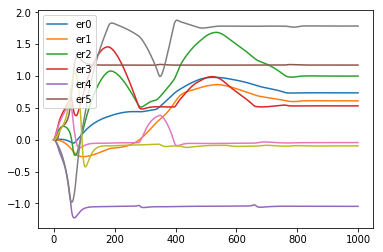

In [34]:
#some plotting
plot(u_vals_hist)
legend(['u' + str(i) for i in range(num_u)])
figure()
plot(q_pos_hist)
angles = ['th' + str(i) for i in range(num_pos)]
legend(['rootx', 'rootz', 'rooty', *angles])
figure()
plot(q_vel_hist)
figure()

plot(q_pos_hist[:,thigh1_i])
plot(q_pos_hist[:,thigh2_i])
legend(['thigh1', 'thigh2'])
figure()


plot(set_points2 - q_pos_hist)
legend(['er' + str(i) for i in range(num_u)])
#print(u_vals)

In [6]:
bodies_str = [sim.model.body_id2name(i) for i in range(sim.model.nbody)]

sim.data.body_xpos[1:-1].min(axis = 0)

array([-0.09319557,  0.        ,  0.06715275])

In [ ]:
plot(q_pos[])